# Singular Value Decomposition

## References

- MLGuideBook : Singular Value Decomposition
    
    https://mlguidebook.com/en/latest/MathExploration/SingularValueDecomposition.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset Preparation

In [2]:
ratings = pd.read_csv('./datasets/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies = pd.read_csv('./datasets/movies.csv')
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Entity to Index Mappers

In [27]:
idx_to_userid_mapper = dict(enumerate(ratings.userId.unique()))
userid_to_idx_mapper = dict(zip(idx_to_userid_mapper.values(), idx_to_userid_mapper.keys()))

idx_to_movieid_mapper = dict(enumerate(ratings.movieId.unique()))
movieid_to_idx_mapper = dict(zip(idx_to_movieid_mapper.values(), idx_to_movieid_mapper.keys()))

In [28]:
ratings['user_idx'] = ratings['userId'].map(userid_to_idx_mapper).apply(np.int32)
ratings['movie_idx'] = ratings['movieId'].map(movieid_to_idx_mapper).apply(np.int32)
ratings.head(5)

,userId,movieId,rating,timestamp,user_idx,movie_idx
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [29]:
movies['movie_idx'] = movies['movieId'].map(movieid_to_idx_mapper).dropna()
movies.head(5)

,movieId,title,genres,movie_idx
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,481.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,482.0
4,5,Father of the Bride Part II (1995),Comedy,483.0


non mapped movies. i.e. non rated movie by any user.

In [31]:
movies[movies.movie_idx.isna()].shape

(18, 4)

## Matrices

### User-Item

In [7]:
user_movie_matrix = ratings.pivot_table(values=['rating'] ,index=['user_idx'], columns=['movie_idx'])
user_movie_matrix.head(5)

rating                                               ...            \
movie_idx   0    1    2    3    4    5    6    7    8    9     ... 9714 9715   
user_idx                                                       ...             
0            4.0  4.0  4.0  5.0  5.0  3.0  5.0  4.0  5.0  5.0  ...  NaN  NaN   
1            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3            NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4            4.0  NaN  NaN  NaN  4.0  NaN  NaN  4.0  NaN  NaN  ...  NaN  NaN   

                                                   
movie_idx 9716 9717 9718 9719 9720 9721 9722 9723  
user_idx                                           
0          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 9724 columns]

In [8]:
X = user_movie_matrix.fillna(0).values

In [ ]:
X.shape

(610, 9724)

### Null values (Unwatched movies)

In [35]:
K = np.isnan(user_movie_matrix.values)
K

array([[False, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False,  True, False, ..., False, False, False]])

### Watched movies

In [36]:
M = ~K
M

array([[ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False,  True, ...,  True,  True,  True]])

## SVD Calculation

In [38]:
U, S, VT = np.linalg.svd(X, full_matrices=False)
U.shape, S.shape, VT.shape

((610, 610), (610,), (610, 9724))

## Eigen values plot

In [39]:
deciles = (np.linspace(0,1,11)*100).astype('int')
dims = np.linspace(1, len(S), 11).astype('int')
deciles, dims

(array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 array([  1,  61, 122, 183, 244, 305, 366, 427, 488, 549, 610]))

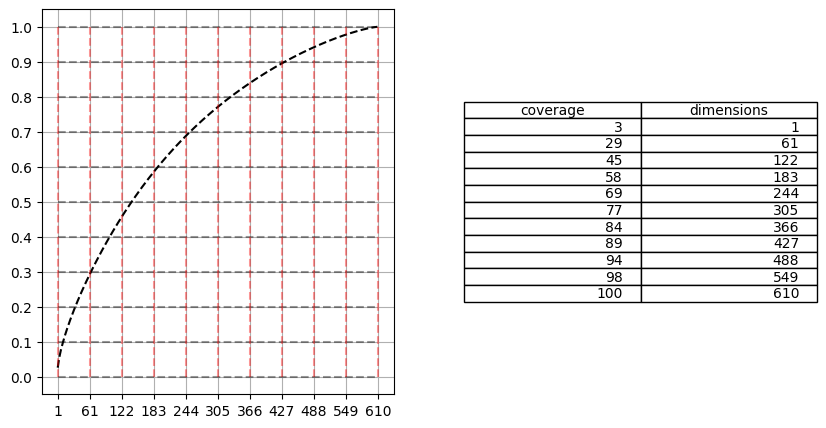

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

eig_value_coverage = S.cumsum()/S.sum()
coverage = np.round(eig_value_coverage[dims-1]*100, 0)
table = np.int32(np.c_[coverage, dims])

ax[0].plot(eig_value_coverage, "--", color='k')
ax[0].hlines(deciles/100, xmin=0, xmax=len(S), alpha=0.4, color='k', linestyle='--')
ax[0].vlines(dims, ymin=0, ymax=1, alpha=0.4, color='r', linestyle='--')

ax[0].set_xticks(dims)
ax[0].set_yticks(deciles/100)
ax[0].grid()

ax[1].table(cellText=table, colLabels=['coverage', 'dimensions'], loc='center')
ax[1].axis('off')

plt.show()

## Low Rank Matrix

In [73]:
def low_rank_matrix(U, S, VT, rank):
    X_tilde = U[:,:rank] @ np.diag(S[:rank]) @ VT[:rank, :]
    return X_tilde

## Loss : RMSE

In [74]:
def loss(X, U, S, VT, rank, M):
    X_tilde = low_rank_matrix(U, S, VT, rank)
    return np.sqrt(np.square(X - X_tilde, where=M).sum())

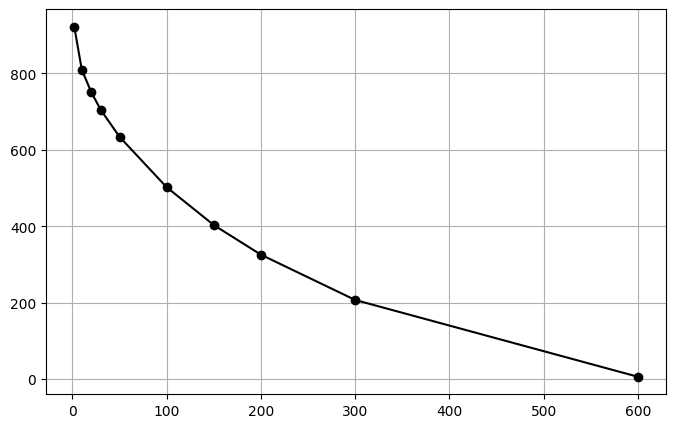

In [75]:
l_losses = []

ranks = [2, 10, 20, 30, 50, 100, 150, 200, 300, 600]
for i in ranks:
    l_losses.append(loss(X, U, S, VT, i, M))

fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.plot(ranks, l_losses, 'ko-')

ax.grid()
plt.show()

## single prediction

In [145]:
def get_prediction(user_idx, movie_idx, U, S, VT, rank=None):
    rank = rank or len(S)
    return np.round(U[user_idx,:rank] @ np.diag(S[:rank]) @ VT[: rank, movie_idx], 2)

In [148]:
user_idx = 0
new_ratings = get_prediction(user_idx, ..., U, S, VT, 100)

In [149]:
new_ratings

array([ 3.48,  3.14,  3.8 , ..., -0.01, -0.01, -0.01])

## user idx based top non watched/rated movie recommendations 

In [192]:
user_idx = 10
rank = 100
top_n_movies = 10

In [193]:
user_vector = user_movie_matrix.iloc[user_idx].values
non_rated_movies_idx = np.isnan(user_vector)
new_movies_ratings = get_prediction(user_idx, ..., U, S, VT, rank)

In [194]:
top_n_idxs = np.c_[np.argsort(new_movies_ratings)][non_rated_movies_idx][::-1][:top_n_movies, 0]
top_n_idxs

array([  7,  20,  25, 463,  34, 472, 232, 121,  42,  26])

In [195]:
(
    ratings[ratings["user_idx"] == user_idx]
    .sort_values(by="rating", ascending=False).head(10)
    .join(other=movies[["movie_idx", "title", "genres"]], on=["movie_idx"], how="inner", rsuffix="x")
)

,userId,movieId,rating,timestamp,user_idx,movie_idx,movie_idxx,title,genres
1259,11,6,5.0,902154266,10,2,1.0,Grumpier Old Men (1995),Comedy|Romance
1272,11,349,5.0,902154342,10,19,3604.0,Money Train (1995),Action|Comedy|Crime|Drama|Thriller
1314,11,1784,5.0,902155043,10,729,3543.0,East of Eden (1955),Drama
1313,11,1721,5.0,902154989,10,987,359.0,This Is Spinal Tap (1984),Comedy
1311,11,1693,5.0,902155102,10,986,2145.0,Ben-Hur (1959),Action|Adventure|Drama
1304,11,1584,5.0,902155136,10,726,3732.0,To Be or Not to Be (1942),Comedy|Drama|War
1299,11,1408,5.0,902154383,10,94,296.0,Nobody Loves Me (Keiner liebt mich) (1994),Comedy|Drama
1293,11,1101,5.0,901200233,10,724,6541.0,Lost Horizon (1937),Drama
1287,11,593,5.0,902155102,10,34,1859.0,It Takes Two (1995),Children|Comedy
1285,11,529,5.0,902155043,10,974,86.0,Highlander (1986),Action|Adventure|Fantasy


In [196]:
movies[movies['movie_idx'].isin(top_n_idxs)]

,movieId,title,genres,movie_idx
97,110,Braveheart (1995),Action|Drama|War,7.0
123,150,Apollo 13 (1995),Adventure|Drama|IMAX,463.0
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,232.0
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,20.0
337,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller,472.0
398,457,"Fugitive, The (1993)",Thriller,25.0
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,26.0
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,34.0
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,42.0
1503,2028,Saving Private Ryan (1998),Action|Drama|War,121.0
